In [10]:
%pip install update
%pip install torch torchvision torchaudio
%pip install torchinfo
%pip install torchsummary
%pip install pytorchcv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


필요 패키지 업데이트 및 실행
#Python 버전 3.10.13 사용

In [11]:
import builtins
import glob
import os
import zipfile
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
#import pytorchcv


default_device = 'cuda' if torch.cuda.is_available() else 'cpu' 
# CUDA 사용할 수 있는지 확인 -> 사용 못하면 CPU로 설정

#from pytorchcv import load_mnist, train, plot_results, plot_convolution, display_dataset 

필요한 라이브러리 호출합니다.

In [12]:
import torchvision.transforms as transforms
def load_fashion_mnist(batch_size=64):
    # Fashion MNIST 학습 데이터셋 불러오기
    fashion_train = torchvision.datasets.FashionMNIST('./data', download=True, train=True, transform=transforms.ToTensor())
    
    # Fashion MNIST 테스트 데이터셋 불러오기
    fashion_test = torchvision.datasets.FashionMNIST('./data', download=True, train=False, transform=transforms.ToTensor())
    
    # 학습 데이터셋 로더 정의
    train_loader = torch.utils.data.DataLoader(fashion_train, batch_size=batch_size)
    
    # 테스트 데이터셋 로더 정의
    test_loader = torch.utils.data.DataLoader(fashion_test, batch_size=batch_size)
    
    return train_loader, test_loader, fashion_train

우선 fashion-MNIST 데이터셋을 사용하여 정보들을 불러옵니다.

In [13]:
train_loader, test_loader, fashion_plot = load_fashion_mnist()

# 데이터셋 확인을 위해 예시로 첫 번째 배치의 데이터를 출력
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)  # 이미지 배치의 크기 출력
print(labels.shape)  # 라벨

torch.Size([64, 1, 28, 28])
torch.Size([64])


이 코드는 load_fashion_mnist 함수의 테스트 코드 실행하게 되면 데이터 셋이 올바르게 로드되었는지 확일할 수 있습니다.

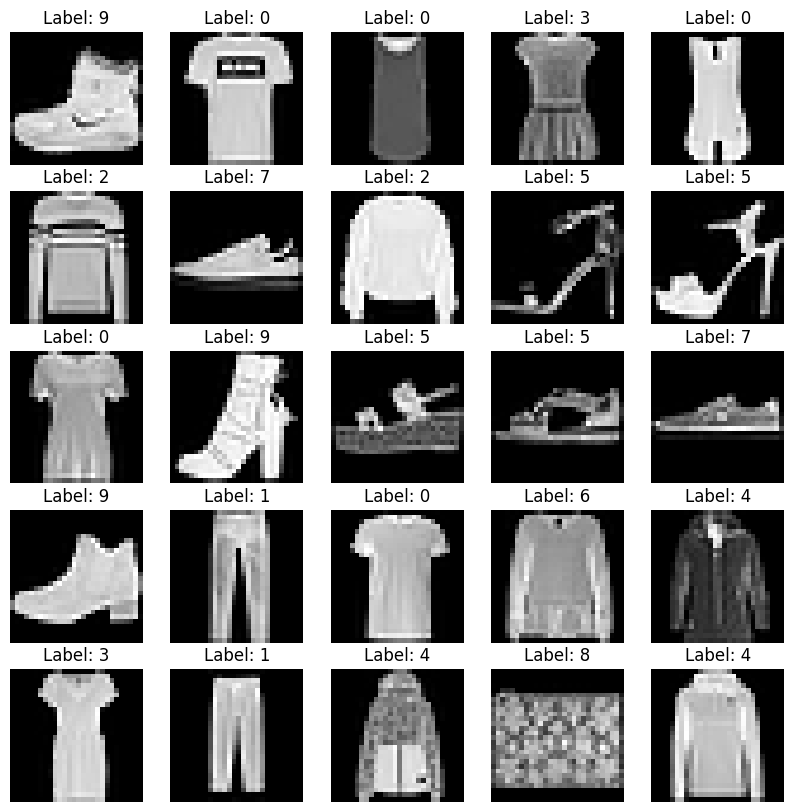

In [14]:
import matplotlib.pyplot as plt

# load_mnist 함수 호출하여 데이터 로드
#train_loader, test_loader = load_fashion_mnist(batch_size=64)

# 첫 번째 배치의 이미지와 레이블 가져오기
images, labels = next(iter(train_loader))

# 이미지 출력하기
plt.figure(figsize=(10, 10)) #그림 크기
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray') # 흑백으로 이미지 설정
    plt.title(f'Label: {labels[i]}') 
    plt.axis('off') # 축 숨기기
plt.show()


이미지와 이미지 분류가 정상적으로 되었는지 확인할 수 있습니다.
상의나 하의는 잘 부류가된 것 같으나 신발은 제 각각 흩어져있다

In [15]:
import torch
import torch.nn as nn

def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = 
                nn.CrossEntropyLoss()): #nn.NLLLoss() 값이 이상하게 출력되어 더 흔히 쓰는 함수로 변경
                #nn.NLLLoss()문 사용하려면 loss_fn(nn.functional.log_softmax(out, dim=1), lbls) 변경 필요
                #nn.NLLLoss() log 확률 계산이 필요한 텐서 
                #nn.CroosEntropyLoss nn.NLLLoss 둘다 별 차이가 없다. 거의 비슷하게 출력. 비교를 위해서는 더 많은 데이터가 필요 
    # 이 함수는 여러 매개변수를 받는데, net은 학습할 신경망 모델, dataloader는 데이터 로더, lr은 학습률(기본값 0.01), 
    # optimizer는 최적화 도구(기본값은 None), loss_fn은 손실 함수로 기본적으로 Negative Log Likelihood Loss를 사용
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr) # 최적화 도구가 제공되지 않았다면, Adam 최적화 도구를 사용하여 신경망의 매개변수를 최적화하며, 학습률은 lr로 설정
    net.train() # 모델을 학습 모드로 설정합니다. 이는 일부 신경망 계층(예: 드롭아웃 계층)이 학습과 평가 모드에서 다르게 동작하기 때문에 필요
    total_loss,acc,count = 0,0,0 # 총 손실, 정확도, 처리한 샘플 수를 초기화
    for features,labels in dataloader: # 데이터 로더로부터 특징(feature)과 레이블(label)을 반복적으로 가져옴
        optimizer.zero_grad() # 최적화 도구의 모든 기울기를 0으로 초기화하는데 새로운 가중치 업데이트를 위해 필수
        lbls = labels.to(default_device) # 레이블을 기본 계산 장치(예: GPU)로 이동
        out = net(features.to(default_device)) # 특징을 같은 장치로 이동시킨 후, 신경망을 통해 예측을 수행
        loss = loss_fn(out,lbls) #cross_entropy(out,labels) 예측 결과와 레이블을 이용해 손실을 계산
        loss.backward() # 손실에 대한 기울기를 계산
        optimizer.step() # 계산된 기울기를 이용해 신경망의 가중치를 업데이트
        total_loss+=loss # 총 손실을 누적
        _,predicted = torch.max(out,1) # 예측된 결과 중 가장 높은 확률을 가진 클래스를 선택
        acc+=(predicted==lbls).sum() # 정확하게 예측된 수를 누적
        count+=len(labels) # 처리된 레이블의 수를 누적
    return total_loss.item()/count, acc.item()/count # 평균 손실과 정확도를 반환

epoch(학습 과정)하는 동안 생기는 평균 손실과 정확도 출력을 위한 함수

In [16]:
# 파이토치(PyTorch)를 사용하여 간단한 신경망 모델을 정의하고, 그 구조를 요약해서 출력하는 과정을 설명

import torch
import torch.nn as nn

class Simple(nn.Module): #간단한 의류 종류를 위한 CNN신경망 모델
    def __init__(self):
        super(Simple, self).__init__()
        # 첫 번째 컨볼루션 레이어: 1개의 입력 채널, 16개의 출력 채널, 3x3 커널 크기, 패딩 1
        # 특징맵 생성
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        # 맥스 풀링 레이어: 2x2 커널 크기, 스트라이드 2
        # 특징 맵의 크기 줄이는 역할
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 완전 연결 레이어: 16개의 입력 채널(컨볼루션 레이어의 출력 크기), 10개의 출력 채널(클래스 개수)
        # 평탄화된 데이터 저장
        self.fc = nn.Linear(16 * 14 * 14, 10)  # Fully connected layer

    def forward(self, x):
        # 입력 이미지를 첫 번째 컨볼루션 레이어에 전달하여 활성화 함수를 적용하고 풀링을 수행합니다.
        x = self.pool(nn.functional.relu(self.conv1(x)))
        # 2차원 특징 맵을 1차원으로 평탄화합니다.
        x = torch.flatten(x, 1)
        # 평탄화된 특징을 완전 연결 레이어에 전달하여 최종 출력을 생성합니다.
        x = self.fc(x)
        return x

# 모델 인스턴스 생성
model = Simple()

# train_epoch 함수 호출
train_loss, train_acc = train_epoch(model, train_loader)

# 결과 출력
print(f"Training Loss: {train_loss}, Training Accuracy: {train_acc}")


# Print the summary of the model
#summary(model,input_size=(1,1,28,28)) # 생성된 모델 net의 요약 정보를 출력하는데 여기서 input_size는 모델이 기대하는 입력 데이터의 크기를 (채널 수, 높이, 너비) 형식으로 지정

Training Loss: 0.006137597147623698, Training Accuracy: 0.8615666666666667


학습과정에의 평균 손실과 정확도를 확인할 수 있습니다.
여러번 실행 해보면 약0.002~0.006의 평균 손실 약 0.8~0.9의 정확도를 가집니다.
##계속 실행을 해보니 정확도는 계속 오르고 손실은 계속 떨어지는 현상이 보입니다. (1에 가까워짐)
인공지능이 다양성이 떨어지는 반복 학습(똑같은 계속 돌림)을 하면서 정확도가 오르는 것으로 보입니다.

In [17]:
""" import torch.nn.init as init

def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        init.normal_(m.weight.data, mean=0, std=0.01)
        if m.bias is not None:
            init.constant_(m.bias.data, 0)

# 모델에 초기화 함수를 적용
model.apply(initialize_weights)
"""

' import torch.nn.init as init\n\ndef initialize_weights(m):\n    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):\n        init.normal_(m.weight.data, mean=0, std=0.01)\n        if m.bias is not None:\n            init.constant_(m.bias.data, 0)\n\n# 모델에 초기화 함수를 적용\nmodel.apply(initialize_weights)\n'

과적합(똑같은 데이터에 너무 익숙해져 표기된 정확도와 달리 잘못된 데이터 처리 현상이 생기는 것을 말함) 현상이 생길떄 사용하기 위한 가중치 초기화문입니다.

In [18]:
def validate(net, dataloader,loss_fn=nn.CrossEntropyLoss()): # validate 함수를 정의하고, 세 개의 매개변수를 받는데 net은 평가할 신경망 모델, dataloader는 평가 데이터셋을 로딩하는 데이터 로더, loss_fn은 손실 함수로 기본값은 Negative Log Likelihood Loss
    net.eval() # 모델을 평가(evaluation) 모드로 설정하는데 이 모드에서는 모델의 학습 과정에만 적용되는 특정 기능들(예: 드롭아웃)이 비활성화
    count,acc,loss = 0,0,0 # 총 처리한 데이터의 수, 정확히 예측된 데이터의 수, 그리고 총 손실을 0으로 초기화
    with torch.no_grad(): # 기울기 계산이 수행되지 않는데 평가 시에는 모델의 가중치가 갱신되지 않음
        for features,labels in dataloader: # 데이터 로더에서 데이터 배치를 반복적으로 가져오는데 각 배치는 features (특징 데이터)와 labels (레이블 데이터)로 구성
            lbls = labels.to(default_device) # 레이블을 기본 계산 장치(예: GPU)로 이동
            out = net(features.to(default_device)) # 특징 데이터도 같은 계산 장치로 이동한 후, 신경망 모델을 통해 예측을 수행
            loss += loss_fn(out,lbls) # 예측 결과와 실제 레이블을 사용하여 손실을 계산하고, 총 손실에 누적
            pred = torch.max(out,1)[1] # 신경망의 출력에서 가장 높은 값을 가진 클래스의 인덱스를 추출하여 예측 결과로 사용
            acc += (pred==lbls).sum() # 예측이 정확했던 샘플의 수를 누적
            count += len(labels) # 처리한 레이블의 총 수를 누적
    return loss.item()/count, acc.item()/count # 평균 손실과 평균 정확도를 계산하여 반환

학습된 모델을 평가하고 성능을 측정하 위한 함수

In [19]:
validation_loss, validation_accuracy = validate(model, train_loader)
print(f"Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}")


Validation Loss: 0.005343145751953125, Validation Accuracy: 0.8780333333333333


학습된 모델의 평균 손실과 정확도를 확인할 수 있습니다.
여러번 실행해보면 약 0.002~0.004의 평균 손실 약 0.8~0.9의 평균 정확도를 가집니다.
이를 미루어 보아 train_epoch가 validate방식보다 좋은 효율을 보일떄도 있지만 train_epoch(학습하면서 최적화 과정을 거치면 평균 손실&정확도 계산)가 최적화 과정을 거치면서도 학습을 마치고 평가를 받는 validate함수보다 높은 손실과 낮은 정확도를 가질떄도 있다.
##계속 실행을 해보니 정확도는 계속 오르고 손실은 계속 떨어지는 현상이 보입니다. 
이도 인공지능의 비슷한 데이터의 반복 학습으로 인한 현상인 것 같습니다.
 

In [20]:
# 신경망 모델을 여러 에폭(epoch) 동안 학습하고 평가하는 과정을 정의하는 Python 함수

def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.CrossEntropyLoss()): # train 함수를 정의 - net: 학습할 신경망 모델; train_loader와 test_loader: 학습 및 테스트 데이터셋을 로드하는 데 사용되는 데이터 로더; optimizer: 최적화 도구 (기본적으로 None이며, 지정되지 않았을 경우 Adam 최적화 도구가 사용); lr: 학습률 (기본값은 0.01); epochs: 전체 학습 과정을 반복할 횟수 (기본값은 10); loss_fn: 손실 함수 (기본값은 Negative Log Likelihood Loss)
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr) # 최적화 도구 (기본적으로 None이며, 지정되지 않았을 경우 Adam 최적화 도구가 사용하며, 학습률은 lr로 설정)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []} # 학습 및 검증 과정에서 계산된 손실과 정확도를 저장할 딕셔너리를 초기화
    for ep in range(epochs): # 지정된 에폭 수만큼 반복
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn) # train_epoch 함수를 호출하여 한 에폭 동안의 학습을 수행하고, 학습 손실(tl)과 정확도(ta)를 반환 받음
        vl,va = validate(net,test_loader,loss_fn=loss_fn) # validate 함수를 호출하여 모델을 검증 데이터셋에 대해 평가하고, 검증 손실(vl)과 정확도(va)를 반환 받음
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}") # 에폭, 학습 정확도, 검증 정확도, 학습 손실, 검증 손실을 출력
        res['train_loss'].append(tl) # 각 결과 값을 딕셔너리에 추가
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res # 학습과 검증 과정에서의 결과를 담은 딕셔너리를 반환

위에서 직접 돌리면서 비교하는 것보다는 함수로 구현해 여러번 반복을 통해 비교해 보자

In [21]:

result = train(model, train_loader, test_loader)

# 학습 및 검증 과정에서의 결과 출력
print("Training Loss:", result['train_loss'])
print("Training Accuracy:", result['train_acc'])
print("Validation Loss:", result['val_loss'])
print("Validation Accuracy:", result['val_acc'])

Epoch  0, Train acc=0.893, Val acc=0.887, Train loss=0.005, Val loss=0.005
Epoch  1, Train acc=0.901, Val acc=0.881, Train loss=0.004, Val loss=0.005
Epoch  2, Train acc=0.908, Val acc=0.880, Train loss=0.004, Val loss=0.006
Epoch  3, Train acc=0.913, Val acc=0.872, Train loss=0.004, Val loss=0.006
Epoch  4, Train acc=0.916, Val acc=0.889, Train loss=0.004, Val loss=0.006
Epoch  5, Train acc=0.919, Val acc=0.883, Train loss=0.003, Val loss=0.006
Epoch  6, Train acc=0.922, Val acc=0.875, Train loss=0.003, Val loss=0.006
Epoch  7, Train acc=0.923, Val acc=0.871, Train loss=0.003, Val loss=0.007
Epoch  8, Train acc=0.924, Val acc=0.877, Train loss=0.003, Val loss=0.006
Epoch  9, Train acc=0.927, Val acc=0.874, Train loss=0.003, Val loss=0.007
Training Loss: [0.004738977559407552, 0.004260131327311198, 0.003952822875976563, 0.0037290056864420574, 0.0036022982279459636, 0.0034541163126627604, 0.003360894266764323, 0.0032782699584960936, 0.003236924489339193, 0.003142034912109375]
Training A

여기서 볼 수 있듯이 서로 엎치락 뒤차락하는 모습을 볼 수 있습니다.

In [22]:
def train_long(net,train_loader,test_loader,epochs=5,lr=0.01,optimizer=None,loss_fn = nn.CrossEntropyLoss(),print_freq=10): # train_long 함수를 정의 - net: 학습할 신경망 모델; train_loader, test_loader: 각각 학습과 검증 데이터를 로드하는 데 사용되는 데이터 로더; epochs: 전체 학습을 반복할 횟수, 기본값은 5; lr: 학습률, 기본값은 0.01; optimizer: 최적화 도구, 기본적으로 None이며, 제공되지 않았을 경우 Adam 최적화 도구를 사용; loss_fn: 손실 함수, 기본값은 Negative Log Likelihood Loss); print_freq: 학습 상태를 출력할 빈도
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr) # 최적화 도구가 제공되지 않은 경우, Adam 최적화 도구를 사용
    for epoch in range(epochs): # 지정된 횟수만큼 에폭을 반복
        net.train() # 모델을 학습 모드로 설정
        total_loss,acc,count = 0,0,0 # 총 손실, 정확도 계산을 위한 누적된 정확도, 그리고 처리된 데이터 수를 초기화
        for i, (features,labels) in enumerate(train_loader): # 학습 데이터 로더로부터 데이터 배치를 가져옴
            lbls = labels.to(default_device) # 레이블을 기본 계산 장치로 이동
            optimizer.zero_grad() # 기울기 버퍼를 0으로 초기화
            out = net(features.to(default_device)) # 특징 데이터를 기본 계산 장치로 이동시킨 후, 모델을 통해 예측을 수행
            loss = loss_fn(out,lbls) # 예측 결과와 레이블을 사용하여 손실을 계산
            loss.backward() # 손실에 대한 기울기를 계산
            optimizer.step() # 계산된 기울기를 사용하여 모델의 가중치를 갱신
            total_loss+=loss # 총 손실을 누적
            _,predicted = torch.max(out,1) # 예측된 결과 중 가장 높은 값을 가진 클래스의 인덱스를 추출
            acc+=(predicted==lbls).sum() # 정확하게 예측된 샘플 수를 누적
            count+=len(labels) # 처리된 레이블 수를 누적
            if i%print_freq==0: # 지정된 빈도마다 현재까지의 학습 상태를 출력
                print("Epoch {}, minibatch {}: train acc = {}, train loss = {}".format(epoch,i,acc.item()/count,total_loss.item()/count))
        vl,va = validate(net,test_loader,loss_fn) # 에폭이 끝날 때마다 검증 함수를 호출하여 검증 손실과 정확도를 계산
        print("Epoch {} done, validation acc = {}, validation loss = {}".format(epoch,va,vl)) # 에폭의 학습 결과와 검증 결과를 출력

이 함수는 앞서 train함수보다 더 세세하게 보기 위한 함수입니다. train_epoch함수에서 학습하고 최척화하고나서 바로바로 학습 손실 및 정확도를 출력하게 했습니다.

In [23]:
train_long(model, train_loader, test_loader)

Epoch 0, minibatch 0: train acc = 0.953125, train loss = 0.0023501215036958456
Epoch 0, minibatch 10: train acc = 0.9375, train loss = 0.002893567762591622
Epoch 0, minibatch 20: train acc = 0.9263392857142857, train loss = 0.0032174019586472284
Epoch 0, minibatch 30: train acc = 0.9243951612903226, train loss = 0.003188792255616957
Epoch 0, minibatch 40: train acc = 0.921875, train loss = 0.0032434703373327486
Epoch 0, minibatch 50: train acc = 0.9224877450980392, train loss = 0.003224060815923354
Epoch 0, minibatch 60: train acc = 0.9246926229508197, train loss = 0.0031182230984578368
Epoch 0, minibatch 70: train acc = 0.9269366197183099, train loss = 0.0030161050004018863
Epoch 0, minibatch 80: train acc = 0.9290123456790124, train loss = 0.002969155524983818
Epoch 0, minibatch 90: train acc = 0.9289148351648352, train loss = 0.0029986962512299257
Epoch 0, minibatch 100: train acc = 0.9297648514851485, train loss = 0.002983100638531222
Epoch 0, minibatch 110: train acc = 0.930320945

train함수와 마찬가지로 계속 엎취락뒤치락하는 모습을 볼 수 있습니다.

이 함수(다른 함수를 돌려도-train_epoch, train, validate)를 계속 돌려보면 train_epoch방식은 계속해서 올라 1에 가까워지기도하고 1이 되기도 합니다. validate 방식은 게속 오르다 일정 수준에서 멈추나 이 역시 이전에 비해 정확도는 오르고 손실이 내려갔습니다.

위에서도 실험해 봤듯이 인공지능이 다영성이 떨어지고 똑같은 데이터를 학습하다보니 정확도가 계속해서 오르는것으로 보입니다. 이렇게 되면 다른 데이터를 잘못 분류하는 현상(우리가 의도하지 않은)이 발생할 수도 있습니다.




In [24]:
# 학습 및 검증 데이터에 대한 정확도와 손실을 시각화하는 Python 함수인데 Matplotlib 라이브러리를 사용하여 결과를 그래프로 표시

def plot_results(hist): # plot_results라는 함수를 정의하는데 hist라는 이름의 딕셔너리를 매개변수로 받는데 학습과 검증 과정의 정확도와 손실이 배열 형태로 저장되어 있음
    plt.figure(figsize=(15,5)) # 새로운 그래프 창을 만들고, 크기를 가로 15인치, 세로 5인치로 설정
    plt.subplot(121) # 두 개의 그래프를 나란히 표시하기 위해 첫 번째 위치(1행 2열의 첫 번째)에 서브플롯을 생성
    plt.plot(hist['train_acc'], label='Training acc') # hist 딕셔너리에서 학습 정확도(train_acc)를 추출하여 그래프로 그리는데 라벨을 'Training acc'로 지정하여 그래프에 범례를 추가
    plt.plot(hist['val_acc'], label='Validation acc') # hist 딕셔너리에서 검증 정확도(val_acc)를 추출하여 그래프로 그리는데 라벨을 'Validation acc'로 지정
    plt.legend() # 그래프에 범례를 추가하는데 각 데이터 세트를 구분하기 위해 사용
    plt.subplot(122) # 두 번째 위치(1행 2열의 두 번째)에 또 다른 서브플롯을 생성
    plt.plot(hist['train_loss'], label='Training loss') # hist 딕셔너리에서 학습 손실(train_loss)을 추출하여 그래프로 그린는데 라벨을 'Training loss'로 지정
    plt.plot(hist['val_loss'], label='Validation loss') # hist 딕셔너리에서 검증 손실(val_loss)을 추출하여 그래프로 그리는데 라벨을 'Validation loss'로 지정
    plt.legend() # 그래프에 범례를 추가

train함수에서 리턴하는 값을 넘겨줘서 데이터(정확도와 손실)를 시각화하는 함수입니다. 

Epoch  0, Train acc=0.930, Val acc=0.869, Train loss=0.003, Val loss=0.008
Epoch  1, Train acc=0.932, Val acc=0.875, Train loss=0.003, Val loss=0.008
Epoch  2, Train acc=0.932, Val acc=0.876, Train loss=0.003, Val loss=0.008
Epoch  3, Train acc=0.933, Val acc=0.874, Train loss=0.003, Val loss=0.008
Epoch  4, Train acc=0.933, Val acc=0.874, Train loss=0.003, Val loss=0.008
Epoch  5, Train acc=0.934, Val acc=0.870, Train loss=0.003, Val loss=0.008
Epoch  6, Train acc=0.935, Val acc=0.876, Train loss=0.003, Val loss=0.008
Epoch  7, Train acc=0.933, Val acc=0.874, Train loss=0.003, Val loss=0.009
Epoch  8, Train acc=0.934, Val acc=0.867, Train loss=0.003, Val loss=0.009
Epoch  9, Train acc=0.935, Val acc=0.872, Train loss=0.003, Val loss=0.009


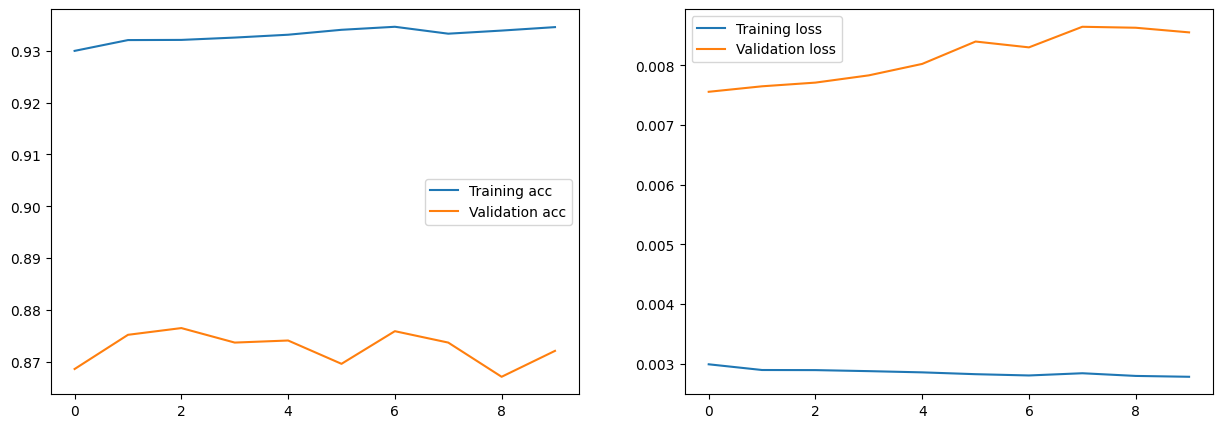

In [25]:
plot_results(train(model, train_loader, test_loader))

일단 학습을 초기화 시키고 다시 진행을 하면 표에서는 validation  손실과 정확도에 대해서 일정하지만 train_epoch방식은 계속해서 정확도는 오르고 손실은 계속 떨어진다. 정확도가 오르는 것은 극정적이나 같은 데이터에 대한 반복적인 학습 때문에 생기는 과적합 현상일 수도 있기에 마냥 긍정적이지는 않은 것 같습니다.

In [26]:
def plot_convolution(t, title=''): 
    # 이 블록 내에서는 PyTorch의 자동 미분 기능을 비활성화하여, 연산에 대한 기울기 계산을 수행하지 않는데 메모리 사용을 줄이고 연산 속도를 향상
    with torch.no_grad(): 
        # 주어진 커널 크기와 채널 수로 2D 컨볼루션 레이어를 생성합니다.
        c = nn.Conv2d(kernel_size=(3,3), out_channels=1, in_channels=1) 
         # 입력된 텐서 t를 컨볼루션 레이어의 가중치로 복사하는데 이렇게 설정하면 컨볼루션 연산이 정확히 이 가중치를 사용
        c.weight.copy_(t) 
        # 그래프의 크기를 설정하여 서브플롯을 생성
        fig, ax = plt.subplots(2, 10, figsize=(20, 2)) 
        fig.suptitle(title, fontsize=16) 
        
        # Fashion MNIST 데이터셋을 불러옵니다.
        #fashion_train 불러와지지가 않아 다시 선언


        # Fashion MNIST의 이미지와 라벨을 하나씩 가져와서 처리합니다.
        for i, (images, _) in enumerate(fashion_plot):
            # 10개의 이미지만 처리합니다. 코어 덤프 방지
            if i >= 10:
                break
            im = images[0] 
            # 첫 번째 행의 i번째 서브플롯에 원본 이미지를 표시합니다.
            ax[0][i].imshow(im.squeeze(), cmap='gray') 
            # 두 번째 행의 i번째 서브플롯에 컨볼루션 연산 결과를 표시합니다.
            ax[1][i].imshow(c(im.unsqueeze(0)).squeeze().detach().numpy(), cmap='gray') 
            # 각 서브플롯의 축을 숨깁니다.
            ax[0][i].axis('off') 
            ax[1][i].axis('off') 
        
        # 커널 텐서를 시각화하여 첫 번째 행의 9번째 서브플롯에 표시합니다.
        ax[0,9].imshow(t.squeeze().numpy(), cmap='gray') 
        ax[0,9].axis('off') 
        ax[1,9].axis('off') 
        # 그래프를 표시합니다.
        plt.show()

컨볼루션 연산을 시각화하는 함수입니다. 이를 통해 원본과 컨볼루션 연산 결과를 확인해보자

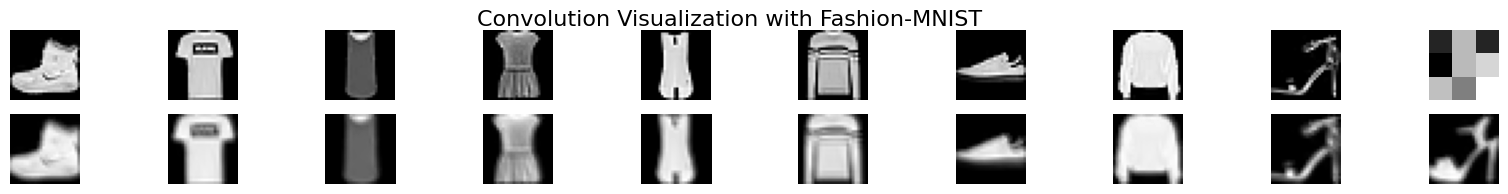

In [27]:
# 커널 텐서 생성
kernel_tensor = torch.rand(1, 1, 3, 3)

# plot_convolution 함수 호출
plot_convolution(kernel_tensor, title='Convolution Visualization with Fashion-MNIST')

컨볼루션 연산을 통해 사진들이 원본보다 흐려졌다. 즉 특정 부분을 강조하기 위해 변환했다고 볼 수 있습니다. fashion-mnsit에서 정한 0-9의 클래스랑 매핑 다르게 되어있습니다.

In [28]:
def display_dataset(dataset, n=10,classes=None): # display_dataset 함수를 정의하며, 매개변수로는 dataset (이미지와 레이블을 포함하는 데이터셋), n (표시할 이미지 수, 기본값은 10), classes (클래스 레이블 이름 배열, 선택적)를 받음
    fig,ax = plt.subplots(1,n,figsize=(15,3)) # 1행 n열의 서브플롯을 생성하고, 전체 그래프의 크기를 가로 15인치, 세로 3인치로 설정
    mn = min([dataset[i][0].min() for i in range(n)]) # 데이터셋에서 선택된 이미지들 중 픽셀 값의 최소값을 계산하는데 값은 이미지 정규화에 사용
    mx = max([dataset[i][0].max() for i in range(n)]) # 데이터셋에서 선택된 이미지들 중 픽셀 값의 최대값을 계산하는데 값은 이미지 정규화에 사용
    for i in range(n): # 0부터 n-1까지의 인덱스에 대해 반복
        ax[i].imshow(np.transpose((dataset[i][0]-mn)/(mx-mn),(1,2,0))) # 각 이미지를 정규화하고, 차원 순서를 변경하여 이미지를 표시하느데 PyTorch에서 일반적으로 사용되는 채널 첫 번째(C, H, W) 형식을 채널 마지막(H, W, C) 형식으로 변환
        ax[i].axis('off') # 각 서브플롯의 축을 숨김
        if classes: # classes 매개변수가 제공되었을 경우, 각 이미지 위에 해당하는 클래스 레이블을 제목으로 설정하는데 dataset[i][1]은 i번째 이미지의 클래스 인덱스
            ax[i].set_title(classes[dataset[i][1]])

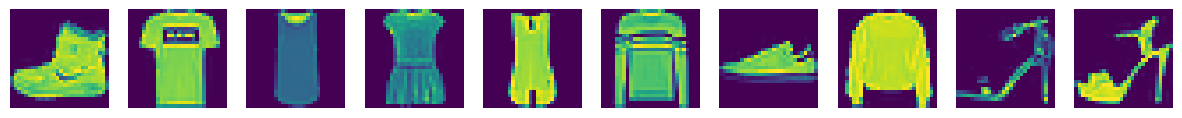

In [29]:
#마찬가지로 fashion_train이 불러와지지가 않아서 다시 선언
display_dataset(fashion_plot)